In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
import seaborn as sns

# tex_fonts = {
#     # Use LaTeX to write all text
#     # "text.usetex": True,
#     "font.family": "serif",
#     "axes.labelsize": 10,
#     "font.size": 10,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 9,
#     "xtick.labelsize": 9,
#     "ytick.labelsize": 9,
# }

# sns.set_theme(
#     # context="talk",
#     context="paper",
#     # rc={"figure.figsize": (8, 6)},
#     # palette="colorblind6",
#     style="whitegrid",
#     rc=tex_fonts,
# )

data = {
    0.5: load_data('../stats/fpm_4_simplices_x0.5.json'),
    1: load_data('../stats/fpm_4_simplices_x1.json'),
    2: load_data('../stats/fpm_4_simplices_x2.json'),
    3: load_data('../stats/fpm_4_simplices_x3.json'),
}

# data = {
#     0.5: load_data('../stats/fpm_4_simplices_solver_2_symmetric_x0.5.json'),
#     1: load_data('../stats/fpm_4_simplices_solver_2_symmetric_x1.json'),
#     2: load_data('../stats/fpm_4_simplices_solver_2_symmetric_x2.json'),
#     # 3: load_data('../stats/fpm_4_simplices_solver_2_symmetric_x3.json'),
# }

# data = {
#     0.5: load_data('../stats/fpm_4_simplices_x0.5_dTPFA.json'),
#     1: load_data('../stats/fpm_4_simplices_x1_dTPFA.json'),
#     2: load_data('../stats/fpm_4_simplices_x2_dTPFA.json'),
#     # 3: load_data('../stats/fpm_4_simplices_x3_dTPFA.json'),
# }

ax_names = {
    0.5: "Cell size: h / 0.5",
    1: "Cell size: h",
    2: "Cell size: h / 2",
    3: "Cell size: h / 3",
    4: "Cell size: h / 4",
    5: "Cell size: h / 5",
    6: "Cell size: h / 6",
}

save_path = "../figures/fpm_4_3D_"

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
shape = [2, 2]
figsize = (12, 4)

Text(0.5, 0.98, '3D, 1 fractures')

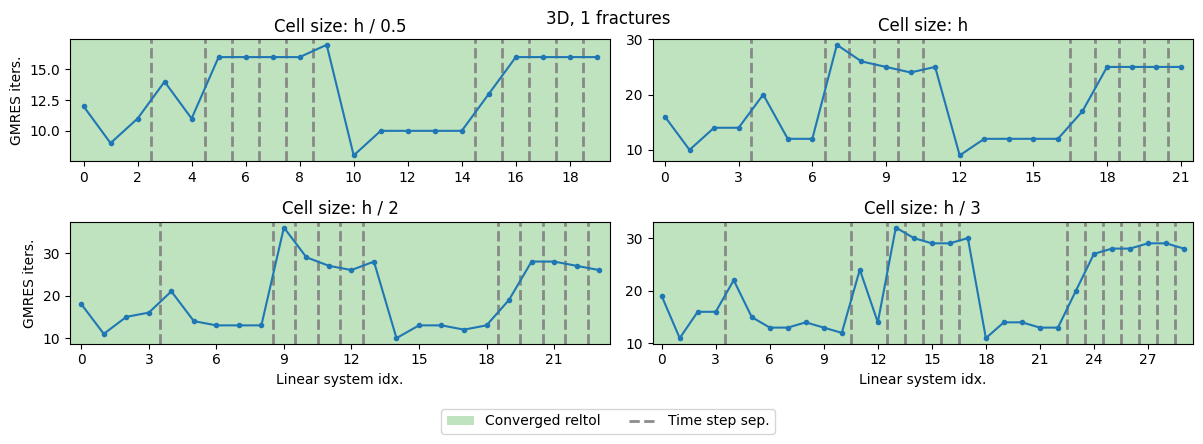

In [3]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=ax_names)
plt.suptitle('3D, 1 fractures')

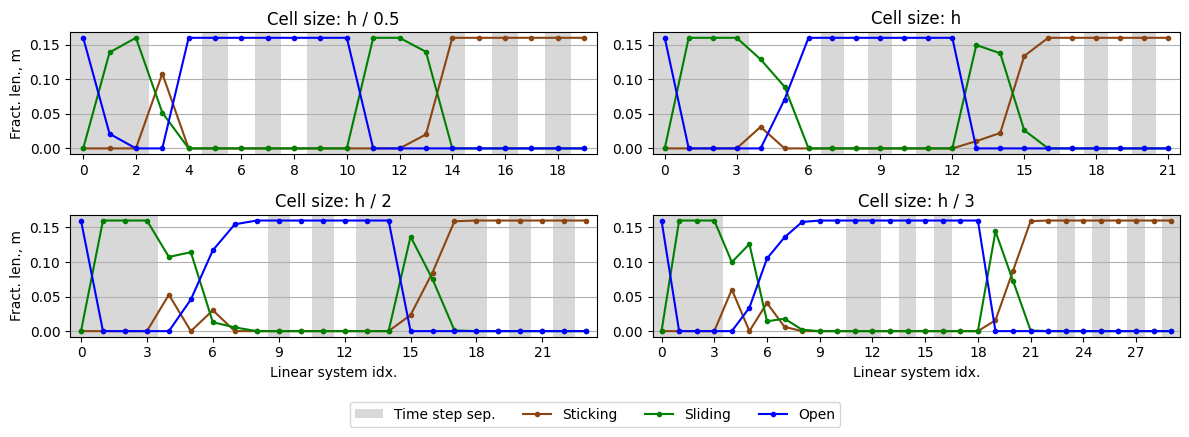

In [4]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    st, sl, op, tr = get_volume_sticking_sliding_open_transition(
        entry, dofs_info_path="../stats/dofs_info_fpm_4_3d.json", cell_size_multiplier=i
    )
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which='major', axis='y')
    plt.plot(st, label="Sticking", marker=".", color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=".", color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=".", color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel="Fract. len., m", ax_titles=ax_names)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

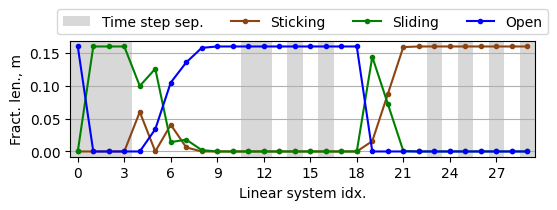

In [5]:
plt.figure(figsize=(6, 1.5))
render_element(i=3, entry=data[3])
plt.ylabel("Fract. len., m")
plt.xlabel("Linear system idx.")
plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=5,
    fancybox=True,
)
plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

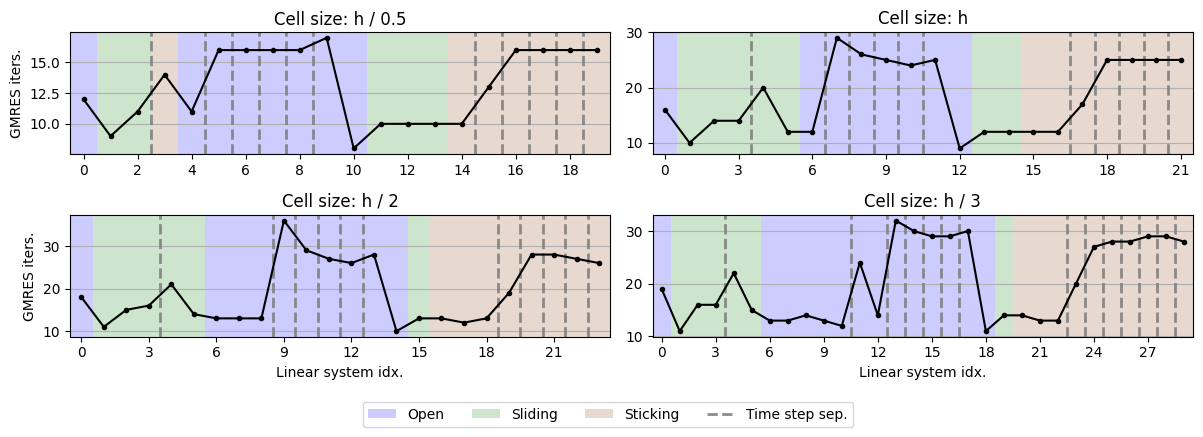

In [6]:
def render_element(i, entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which='major', axis='y')
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=ax_names)
plt.savefig(save_path + 'gmres_fracture_state_exact_inv.pdf', bbox_inches='tight')

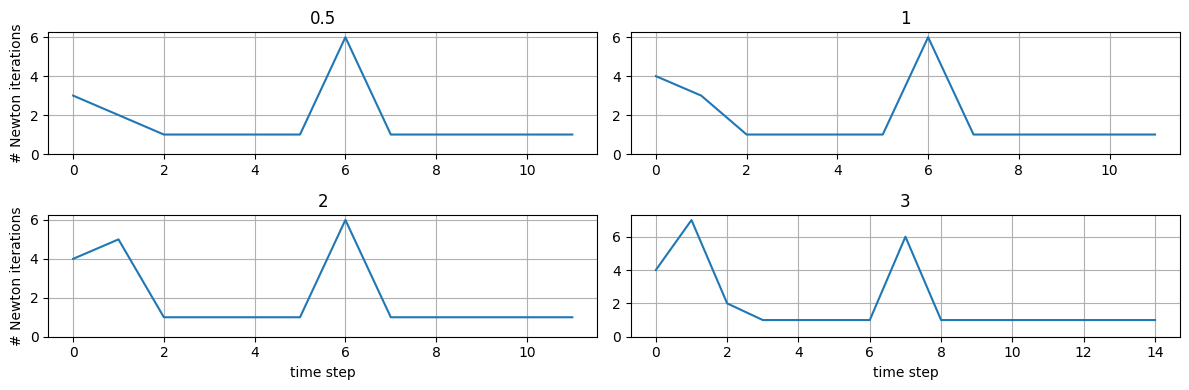

In [7]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid(True)

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step', legend=False)

# Testing bad matrix

In [8]:
assert False

AssertionError: 

In [10]:
from fpm_4_simplices import make_model

cell_size_multiplier = 1
entry = data[cell_size_multiplier]

model = make_model(cell_size_multiplier=cell_size_multiplier)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()

cell_size_multiplier = 1


num sticking: 0
num sliding: 0
num open: 0
num trans: 42


In [17]:
mat_idx = 16
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

12


In [18]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)
model.ad_time_step.set_value(dt)

st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

model.assemble_linear_system()

42
0
0
0


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 0.52
True residual permuted: 5.215390471788068e-11
True residual: 5.215390507634047e-11
PETSc Converged Reason: 2


{'mat_Q': BlockMatrixStorage of shape (19840, 19840) with 5000945 elements with 6x6 active groups,
 'rhs_Q': array([-4.55677222e-07,  1.51668709e-07, -3.41672505e-07, ...,
         5.97784813e-15,  1.03591839e-14,  3.60650346e-15]),
 'prec': <mat_utils.FieldSplit at 0x720a84f6c1d0>}

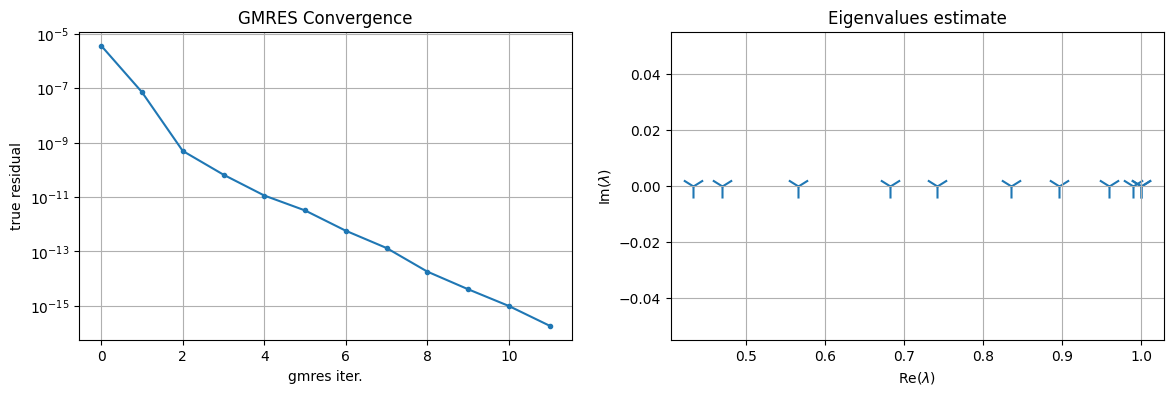

In [19]:
schema = model._prepare_solver()
solve_petsc_new(
    model.bmat,
    schema,
    rhs_global=rhs,
    # Qleft=model._Qleft,
    Qright=model.Qright,
    pc_side="right",
    tol=1e-10,
)

Solve  took: 0.52
True residual permuted: 5.215913230966407e-11
True residual: 5.215913253326583e-11
PETSc Converged Reason: 2


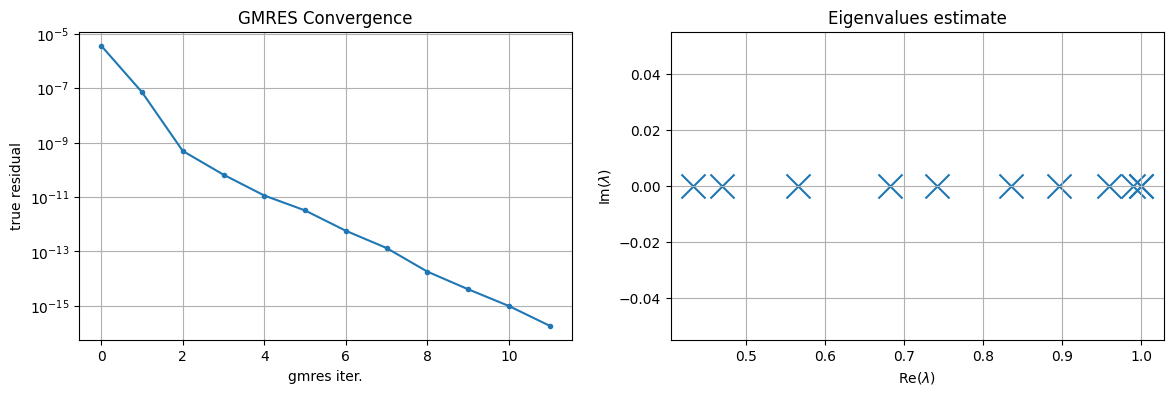

In [31]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import *

schema = SolveSchema(
    groups=[4],
    # only_complement=True,
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # groups=[5],
        # solve=lambda bmat: PetscAMGMechanics(mat=bmat[[5]].mat, dim=model.nd),
        # invertor=lambda bmat: inv_block_diag(bmat[[5]].mat, nd=model.nd, lump=True),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(
                mat=bmat[[1, 5]].mat,
                dim=model.nd,
                null_space=model.build_mechanics_near_null_space(),
            ),
            invertor_type="physical",
            invertor=lambda bmat: make_fs_experimental(model, model.bmat).mat,
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)

res = solve_petsc_new(
    J1,
    schema,
    # Qleft=model._Qleft,
    Qright=model._Qright,
    rhs_global=rhs,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)

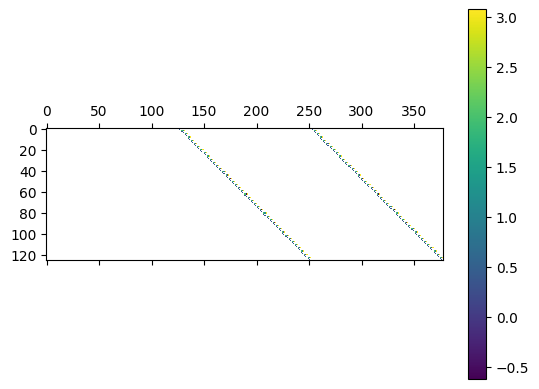

In [26]:
J1 = model.bmat.copy()
J1.set_zeros(4, 4)

J1[[4], [4, 5]].matshow(log=True)